# Impact of Barren Plateaus Mitigation Strategy on the Performance of Quantum Neural Networks
## Merging and transfer of training data from log to legacy folders
**Authors:**
- Jacob Cybulski and Thanh Nguyen

**Date:**
- June 2023

**Specs:**
- Input = Saves folders - Logs (Method, Weights, Loss, Train and Test Scores)
- Output = Record folders - Weights, Loss, Scores (Train and Test)

**Description:**
- This notebook aims to merge and then transfer logged training data to their respective recording folders

In [1]:
from os.path import exists
from os import makedirs
import copy, math
import numpy as np
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [11]:
MAX_INST = 10

# LOGS_PATH = './Logs-IRIS-v4'
LOGS_PATH = './Logs-MNIST-v4'

In [12]:
def plot_method_data(losses, title='Instance Losses', dlabel='inst#', xlabel='Loss', ylabel='Iteration'):
    # create figure and axis
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(8)
    
    # setting the axis' labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # transposing (switchung rows and columns) of DataFrame df and
    # plot a line for each column on the axis ax, which was created previously
    for i in range(len(losses)):
        losses[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
    ax.legend([f'{dlabel} {i}' for i in range(len(losses))],
             loc='lower center', bbox_to_anchor=(0.5, -0.45),
             ncol=5, fancybox=True, fontsize='x-small') #, shadow=True)
    plt.title(title)
    plt.show()

## Logs management

In [13]:
### Reads in all methods records from the log folder
def logs_to_methods_data(log_path, methods=['m0', 'm1', 'm2', 'm3']):
    
    weights = {}
    losses = {}
    scores_train = {}
    scores_test = {}

    if (type(methods) == str):
        methods = [methods]
    elif (not type(methods) == list):
        print('Expected a list of methods, received:', methods)
        return
    
    if (not exists(f'{log_path}')):
        print(f'Invalid archive: {log_path}')
    else:
        print(f'List of a valid archive: {log_path}')
        for mi in methods:
            m = f'{mi}'
            if (not exists(f'{log_path}/{m}')):
                print(f'{" "*3}Missing method: {m}')
            else:
                weights[m] = []
                losses[m] = []
                scores_train[m] = []
                scores_test[m] = []
                new_inst_no = -1
                missing_inst_no = 0
                error_inst_no = 0
                print(f'{" "*3}Found method: {m}')

                for inst in range(MAX_INST):
                    if (not exists(f'{log_path}/{m}/{m}-{inst}-LossFunction.csv')):
                        missing_inst_no += 1
                        print(f'{" "*6}*** Missing method instance: {m}-{inst}')
                    else:
                        print(f'{" "*6}Found method instance: {m}-{inst}')
                        inst_valid = True
                        if (not exists(f'{log_path}/{m}/{m}-{inst}-Weights.csv')):
                            print(f'{" "*9}... Missing weight file: {m}-{inst}-Weights.csv')
                            inst_valid = False
                        if (not exists(f'{log_path}/{m}/{m}-{inst}-Scores-Train.csv')):
                            print(f'{" "*9}... Missing training scores file: {m}-{inst}-Scores-Train.csv')
                            inst_valid = False
                        if (not exists(f'{log_path}/{m}/{m}-{inst}-Scores-Test.csv')):
                            print(f'{" "*9}... Missing testing scores file: {m}-{inst}-Scores_Test.csv')
                            inst_valid = False
                        if (not inst_valid):
                            error_inst_no += 1
                            print(f'{" "*6}*** Corrupted instance: {m}-{inst} - Rejected')
                        else:
                            new_inst_no += 1
                            print(f'{" "*9}... Instance {m}-{inst} renumbered as {new_inst_no}')
                            
                            # Get loss functions
                            inst_loss = pd.read_csv(f'{log_path}/{m}/{m}-{inst}-LossFunction.csv', index_col=[0])
                            losses[m].append(pd.DataFrame(inst_loss['0'].values).T)
                            
                            # Get weights
                            inst_weights = pd.read_csv(f'{log_path}/{m}/{m}-{inst}-Weights.csv', index_col=[0])
                            weights[m].append(inst_weights)
                            
                            # Get training scores
                            inst_scores_train = pd.read_csv(f'{log_path}/{m}/{m}-{inst}-Scores-Train.csv', index_col=[0])
                            scores_train[m].append(pd.DataFrame(inst_scores_train['0'].values).T)
                            
                            # Get testing scores
                            inst_scores_test = pd.read_csv(f'{log_path}/{m}/{m}-{inst}-Scores-Test.csv', index_col=[0])
                            scores_test[m].append(pd.DataFrame(inst_scores_test['0'].values).T)
                if(new_inst_no == -1):
                    print(f'{" "*6}*** No method instances found')
                else:
                    print(f'{" "*6}Method {m} had {new_inst_no+1} valid, {missing_inst_no} missing, and {error_inst_no} in error instances')
                            
    return losses, weights, scores_train, scores_test

In [14]:
### Saves all methods records into a legacy directory
def methods_data_to_legacy_archive(legacy_path, losses, weights, train_scores, test_scores, backup_path=None, methods=['m0', 'm1', 'm2', 'm3']):
    
    # Create a legacy folder if it does not exist
    if (exists(legacy_path)):
        print(f'Existing archive {legacy_path}, extending its structure as needed')
    else:
        print(f'Non existing archive {legacy_path}, creating it with structure')
    
    # Create the structure of the legacy folder if sub-folders do not exist
    for dir in [legacy_path+d for d in ['', '/LossFunction', '/Weights', '/Scores/Train', '/Scores/Test']]:
        if not exists(dir):
            print(f'   Creating directory {dir}')
            makedirs(dir)
    
    # Create weight folders for all methods found in the file and requested
    for m in losses.keys():
        if m in methods:
            print(f'   Working with method {m}')
            if not exists(f'{legacy_path}/Weights/{m}'):
                print(f'   Creating directory for method {m}')
                makedirs(f'{legacy_path}/Weights/{m}')
            else:
                print(f'   Directory for method {m}')
            
    # Save the weights into legacy folders for all methods found in the file and requested
    for m in losses.keys():
        if m in methods:
            if (len(losses[m]) > 0):
                pd.concat(losses[m]).astype('float').to_csv(f'{legacy_path}/LossFunction/{m}.csv')
                pd.concat(train_scores[m]).astype('float').to_csv(f'{legacy_path}/Scores/Train/{m}.csv')
                pd.concat(test_scores[m]).astype('float').to_csv(f'{legacy_path}/Scores/Test/{m}.csv')
                for wr in range(len(weights[m])):
                    weights[m][wr].astype('float').to_csv(f'{legacy_path}/Weights/m3/sample_{wr}.csv')
    return

In [15]:
losses, weights, train_scores, test_scores = \
    logs_to_methods_data(LOGS_PATH)

List of a valid archive: ./Logs-MNIST-v4
   Found method: m0
      Found method instance: m0-0
         ... Instance m0-0 renumbered as 0
      Found method instance: m0-1
         ... Instance m0-1 renumbered as 1
      Found method instance: m0-2
         ... Instance m0-2 renumbered as 2
      Found method instance: m0-3
         ... Instance m0-3 renumbered as 3
      Found method instance: m0-4
         ... Instance m0-4 renumbered as 4
      Found method instance: m0-5
         ... Instance m0-5 renumbered as 5
      Found method instance: m0-6
         ... Instance m0-6 renumbered as 6
      Found method instance: m0-7
         ... Instance m0-7 renumbered as 7
      Found method instance: m0-8
         ... Instance m0-8 renumbered as 8
      Found method instance: m0-9
         ... Instance m0-9 renumbered as 9
      Method m0 had 10 valid, 0 missing, and 0 in error instances
   Found method: m1
      Found method instance: m1-0
         ... Instance m1-0 renumbered as 0
      

In [28]:
sel_method = 'm3'

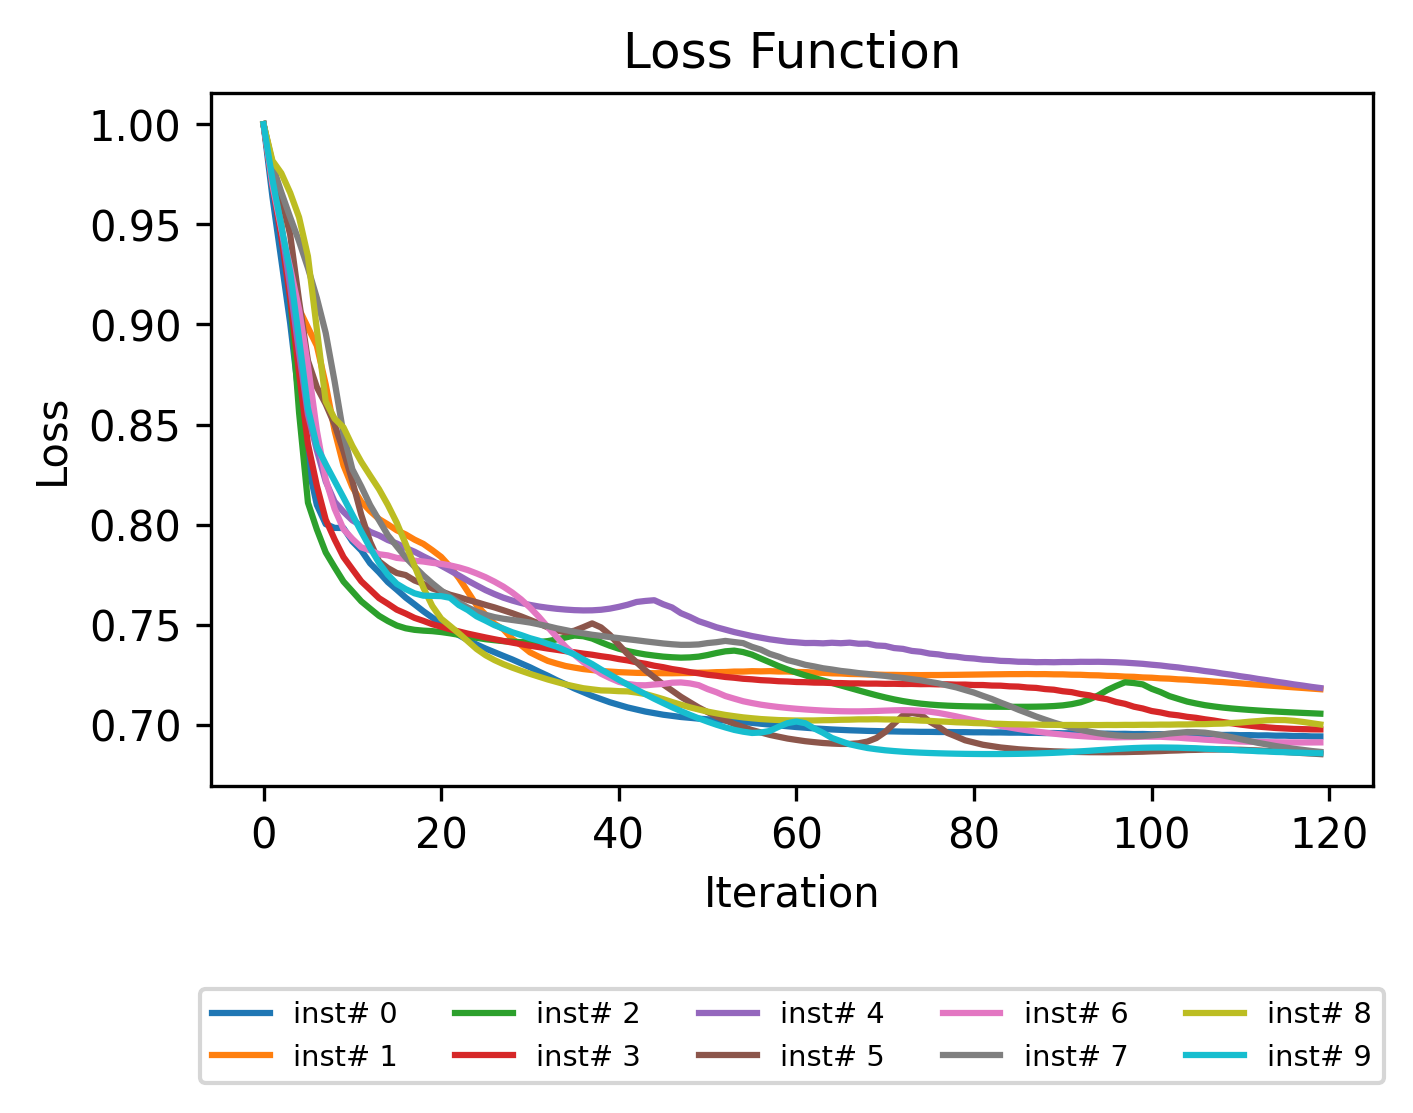

In [29]:
plot_method_data(losses[sel_method], 
                 title='Loss Function', dlabel='inst#', xlabel='Iteration', ylabel='Loss')

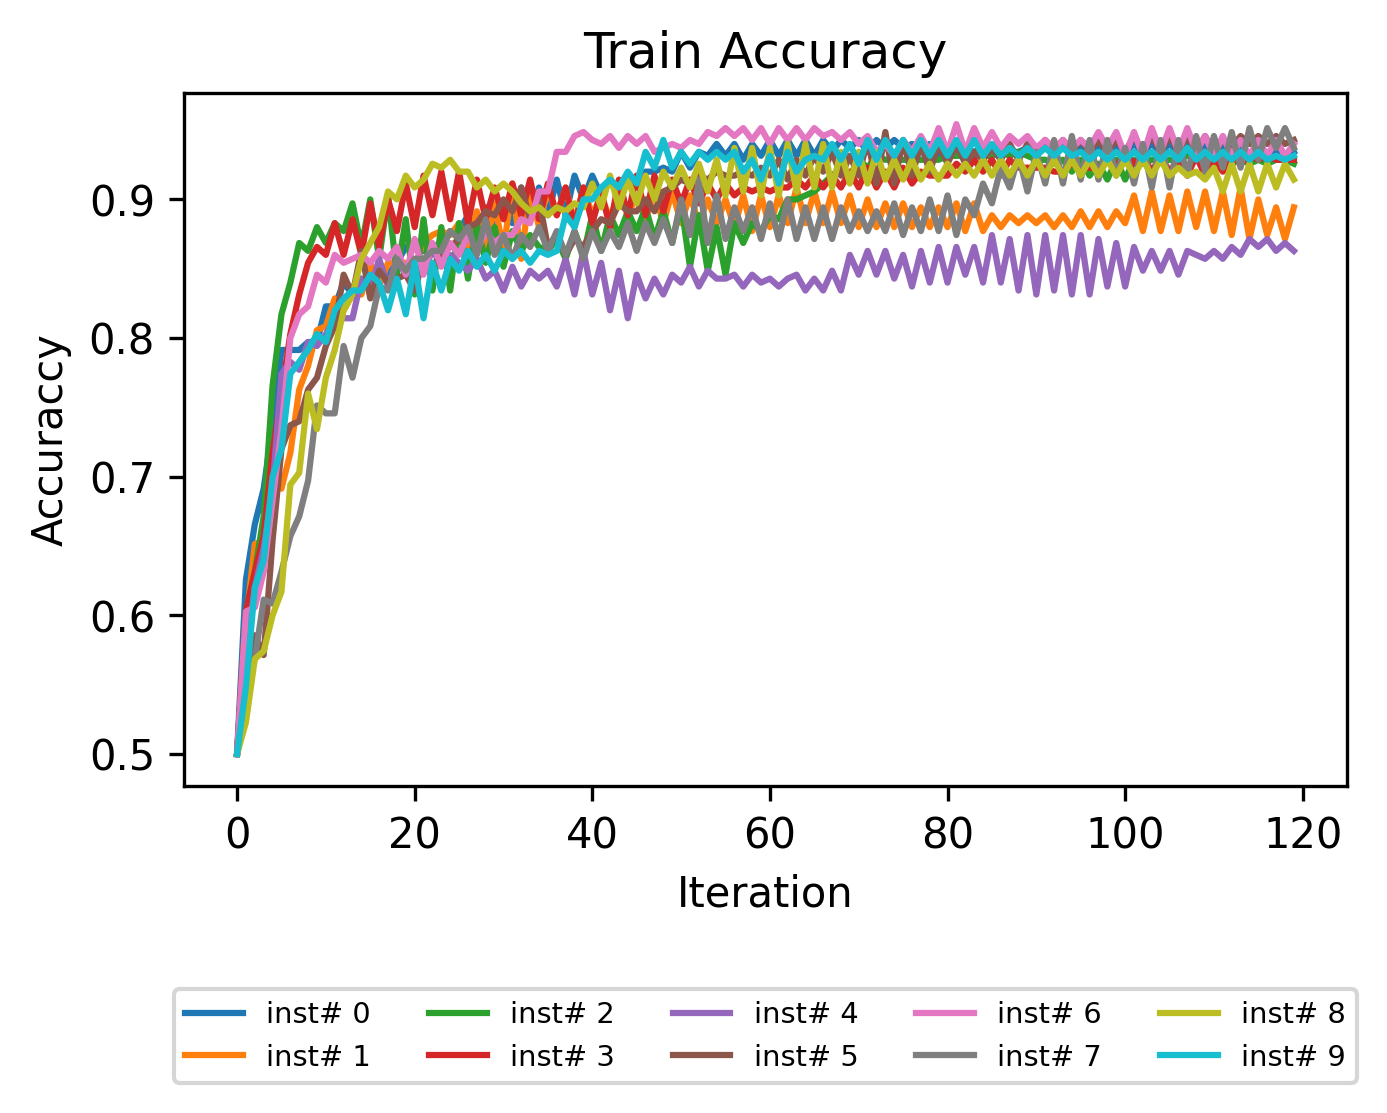

In [30]:
plot_method_data(train_scores[sel_method], 
                 title='Train Accuracy', dlabel='inst#', xlabel='Iteration', ylabel='Accuraccy')

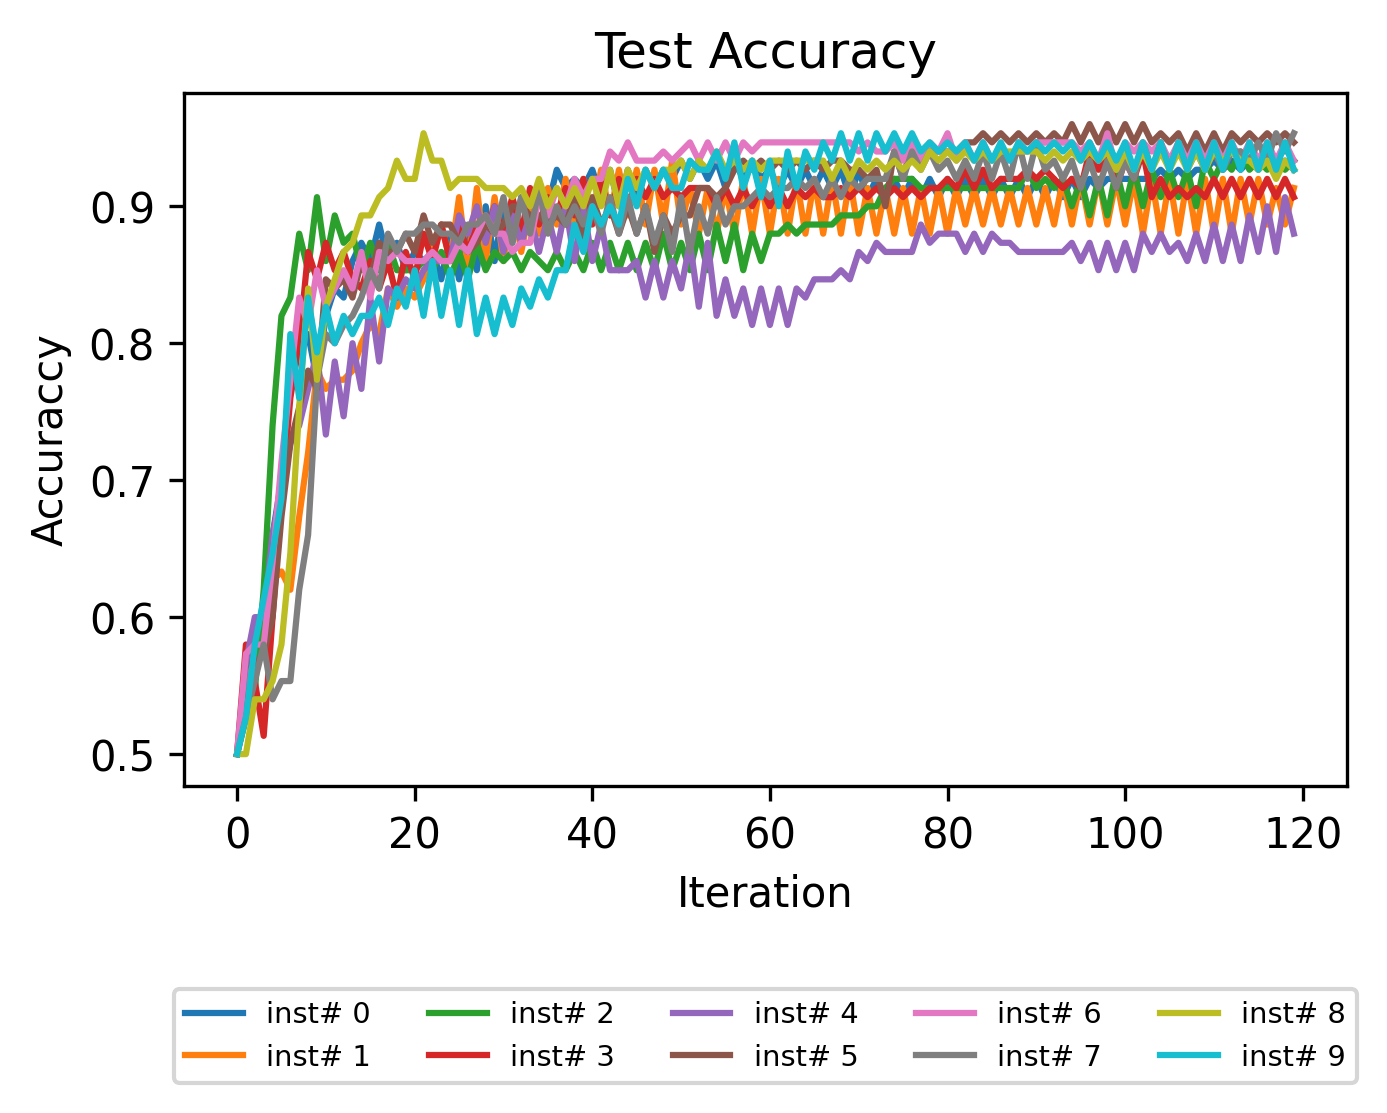

In [31]:
plot_method_data(test_scores[sel_method], 
                 title='Test Accuracy', dlabel='inst#', xlabel='Iteration', ylabel='Accuraccy')

In [62]:
# methods_data_to_legacy_archive(SAVE_V3_PATH, losses, weights, train_scores, test_scores)

In [63]:
!pip list | grep qiskit

qiskit                        0.41.0
qiskit-aer                    0.11.2
qiskit-experiments            0.4.0
qiskit-finance                0.3.4
qiskit-ibm-experiment         0.2.8
qiskit-ibm-provider           0.2.1
qiskit-ibm-runtime            0.8.0
qiskit-ibmq-provider          0.20.0
qiskit-machine-learning       0.5.0
qiskit-nature                 0.5.2
qiskit-optimization           0.5.0
qiskit-terra                  0.23.1


In [64]:
!pip list | grep torch

torch                         1.13.1
torchaudio                    0.13.1
torchsummary                  1.5.1
torchvision                   0.14.1
